<a href="https://colab.research.google.com/github/ariadna-perello/TP1/blob/main/nlp/AIF_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this practical session we will see how to compute documents embeddings and use them for text classification.


1.  In the first part we will use bag of words methods
2.  In the second part we will explore word embeddings methods
3. In the last part you will play with transformers

During all the practical session, you will work on the same dataset [AG's corpus of news article] which will help you to fairly compare each approches.

*AG News (AG’s News Corpus) is a subdataset of [AG's corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus. The AG News contains 30,000 training and 1,900 test samples per class.*  

Let's first download the dataset:

In [1]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv 2>&1
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv 2>&1

--2024-11-28 07:13:40--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv [following]
--2024-11-28 07:13:40--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M   161MB/s    in 0.2s    

2024-11-28 07:13:40 (161 MB/s) - ‘train.csv’ saved [29470338/29470338]

--2024-1

The following code snippet will load the dataset and incorporate the label names into a new column.

In [2]:
import pandas as pd

traindf = pd.read_csv('train.csv', names=["label", "title", "text"]).sample(2000)
testdf = pd.read_csv('test.csv', names=["label", "title", "text"]).sample(1000)

traindf['label'] = traindf['label'] -1
traindf['label_name'] = traindf.label.map({0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"})
testdf['label'] = testdf['label'] -1
testdf['label_name'] = testdf.label.map({0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"})
testdf

,label,title,text,label_name
418,2,ARM agrees to buy Artisan Components for \$903 mn,"LONDON, August 23 (New Ratings) - ARM Holdings...",Business
3669,0,Hostage-taker snubs rescue team,A PAKISTANI militant leader linked to al-Qaeda...,World
6354,2,Ruling delayed in Peoplesoft case,A crucial legal ruling in Oracle's takeover bi...,Business
6758,3,Radeon X850 Released,VisionTek announced today the official launch ...,Sci/Tech
2502,1,Cricket swings to Calypso once again,From the time you touch down in the British Is...,Sports
...,...,...,...,...
4455,0,PITCAIRN TRIAL FINDS 5 OF 7 GUILTY,The three New Zealand judges presiding over se...,World
2456,1,Ichiro Makes Run at Historic Record,"Ichiro Suzuki, baseball #39;s sang-froid playe...",Sports
3646,1,Sports ; IHF awaiting invitation for Champions...,"Sports News, New Delhi, Oct 12 (IANS) The Indi...",Sports
6122,2,Investors expect PeopleSoft shareholders to ba...,"REDWOOD SHORES, Calif. Investors continue to b...",Business



**Begin with Initial Exploration:**

To kick off our analysis, let's start with a bit of exploration.  
Use the [Wordcloud](https://amueller.github.io/word_cloud/) library and follow the example provided in the [documentation](https://amueller.github.io/word_cloud/auto_examples/simple.html#sphx-glr-auto-examples-simple-py) to create a visualization of the most common words in our corpus.

To get started, you can concatenate all the documents into a single text. A straightforward way to do this is by using the `"".join()` function on a list of text...


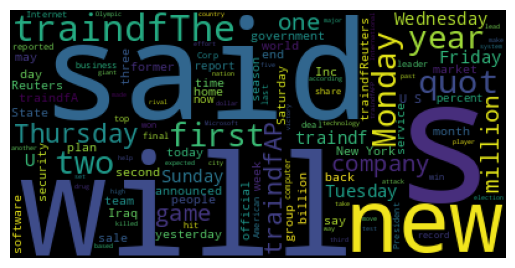

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

corpus = "traindf".join(traindf.text.values)
wordcloud = WordCloud().generate(corpus)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

By default, Wordcloud automatically excludes common English words such as "and," "or," "the," and "a." However, you can customize this list of excluded words to suit your needs.

If you're looking for a powerful library for natural language processing, consider using [NLTK](https://www.nltk.org/). NLTK provides several lists of stopwords that can be used to clean text data.

Even though using NLTK stopwords may not significantly alter the results, let's go ahead and provide Wordcloud with a custom list of stopwords sourced from NLTK.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


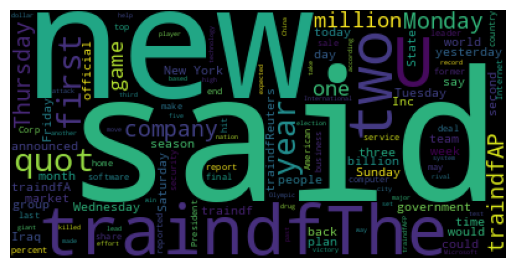

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=stop_words).generate(corpus) #use the stopwords when generating the wordcloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

Now, plot a different wordcloud for every category in the dataset.  
Are you capable of predicting the categories given only these wordclouds?

<class 'pandas.core.series.Series'>


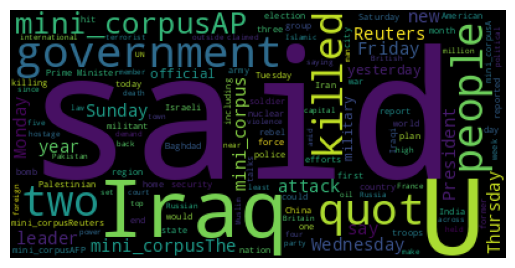

<class 'pandas.core.series.Series'>


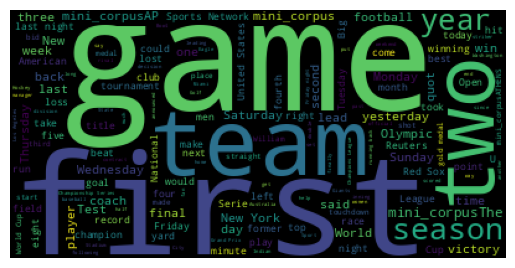

<class 'pandas.core.series.Series'>


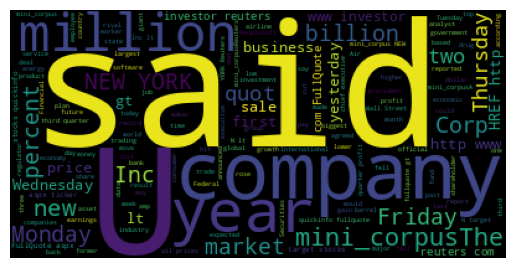

<class 'pandas.core.series.Series'>


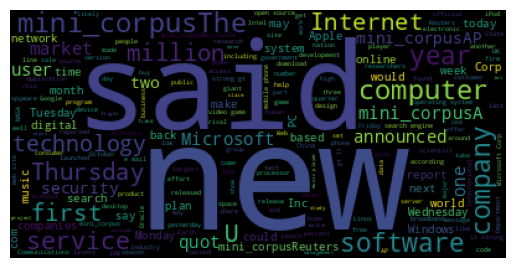

In [39]:
categories = {0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"}
for i in range(0,4):
    mini_corpus = traindf.loc[traindf['label_name']==f'{categories[i]}','text']
    minicorpus = "mini_corpus".join(mini_corpus.values)
    wordcloud = WordCloud(stopwords=stop_words).generate(minicorpus) #use the stopwords when generating the wordcloud
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Bag-of-Words (BoW)

In this section, we will train various models to predict the category of news articles. One of the initial approaches we'll explore is called the "**bag of words**" (BoW) method.

BoW methods represent documents by counting or calculating statistics on the words present within them. Once the bag-of-words is computed, documents are transformed into vectors, with each dimension corresponding to a word/token in the vocabulary of the corpus.

To start, vectorize your documents using term frequencies.   
You can refer to the [documentation of scikit-learn's CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to encode the **text column** of your training set.


In [42]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
train_count_matrix = vectorizer.fit_transform(traindf.text)
print(type(train_count_matrix))

<class 'scipy.sparse._csr.csr_matrix'>


The ```vocabulary_``` argument of your vectorizer contains a dictionary with all the tokens and their corresponding index in the bag-of-words.  
How many unique tokens compose your bag-of-words?

In [43]:
len(vectorizer.vocabulary_)

10337

You can also use the ```get_feature_names_out()``` method to get the list of identified tokens:

In [44]:
vectorizer.get_feature_names_out()

array(['000', '000m', '000th', ..., 'zucchini', 'zurich', 'zvonareva'],
      dtype=object)

Now choose a classification method from scikit-learn and train it to classify news article.  
Print the classification score of your model on the training set.

In [46]:
from sklearn.neural_network import MLPClassifier
X_train=train_count_matrix
y_train=traindf.label_name
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.score(X_train,y_train)

1.0

Now use the ```transform``` method from your vectorizer on the testing set and print the score obtained by your model on the testing set.  
Your model is probably overfitting a lot.  

In [48]:
test_count_matrix = vectorizer.transform(testdf.text)
X_test = test_count_matrix
y_test = testdf.label_name
predictions = clf.predict(X_test)
clf.score(X_test,y_test)

0.836


Plot a [consusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) to see where your model makes the most mistakes.

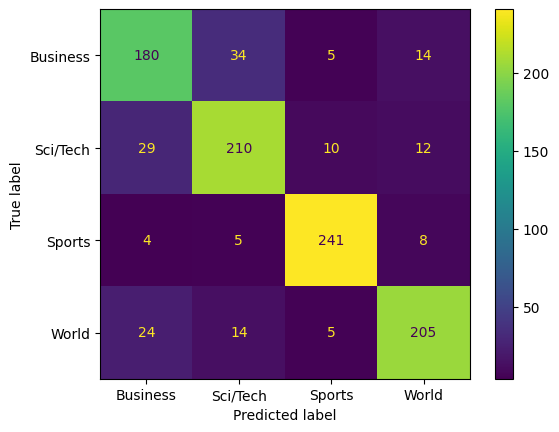

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Play with some of the vectorizer hyper-parameters to see whether you can improve the perfomance of your classifier on the testing set.  
Try adding stopwords or changing the ngram_range...

In [51]:
vectorizer = CountVectorizer(stop_words = 'english')
train_count_matrix = vectorizer.fit_transform(traindf.text)
X_train=train_count_matrix
y_train=traindf.label_name

In [52]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.score(X_train,y_train)

1.0

In [53]:
test_count_matrix = vectorizer.transform(testdf.text)
X_test = test_count_matrix
y_test = testdf.label_name
predictions = clf.predict(X_test)
clf.score(X_test,y_test)

0.842

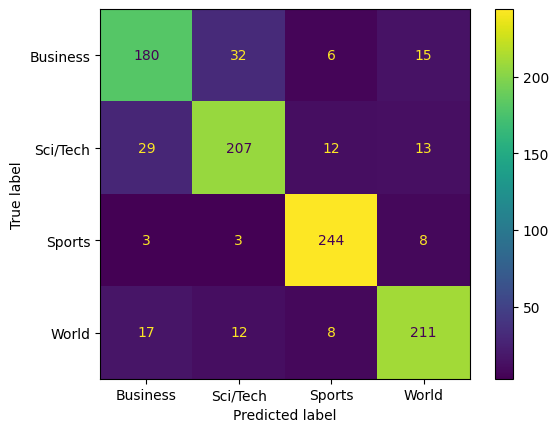

In [54]:
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

train score 1.0
test score 0.773


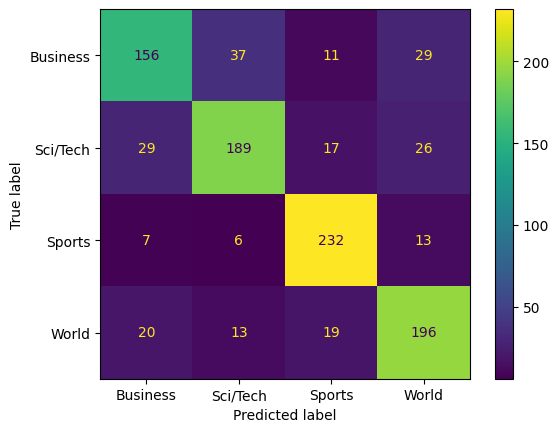

In [56]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
train_count_matrix = vectorizer.fit_transform(traindf.text)
X_train=train_count_matrix
y_train=traindf.label_name
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
print("train score", clf.score(X_train,y_train))
test_count_matrix = vectorizer.transform(testdf.text)
X_test = test_count_matrix
y_test = testdf.label_name
predictions = clf.predict(X_test)
print("test score", clf.score(X_test,y_test))
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Once you are satisfied with the model's performance or find that it's not improving further, you can proceed to plot a [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) visualization of your training representations, using different colors to represent labels.

In particular, compare the t-SNE representations computed with and without stopwords. What observations do you make from this comparison?


<ipython-input-77-fe4ce114e408>:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
<ipython-input-77-fe4ce114e408>:55: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


<Axes: >

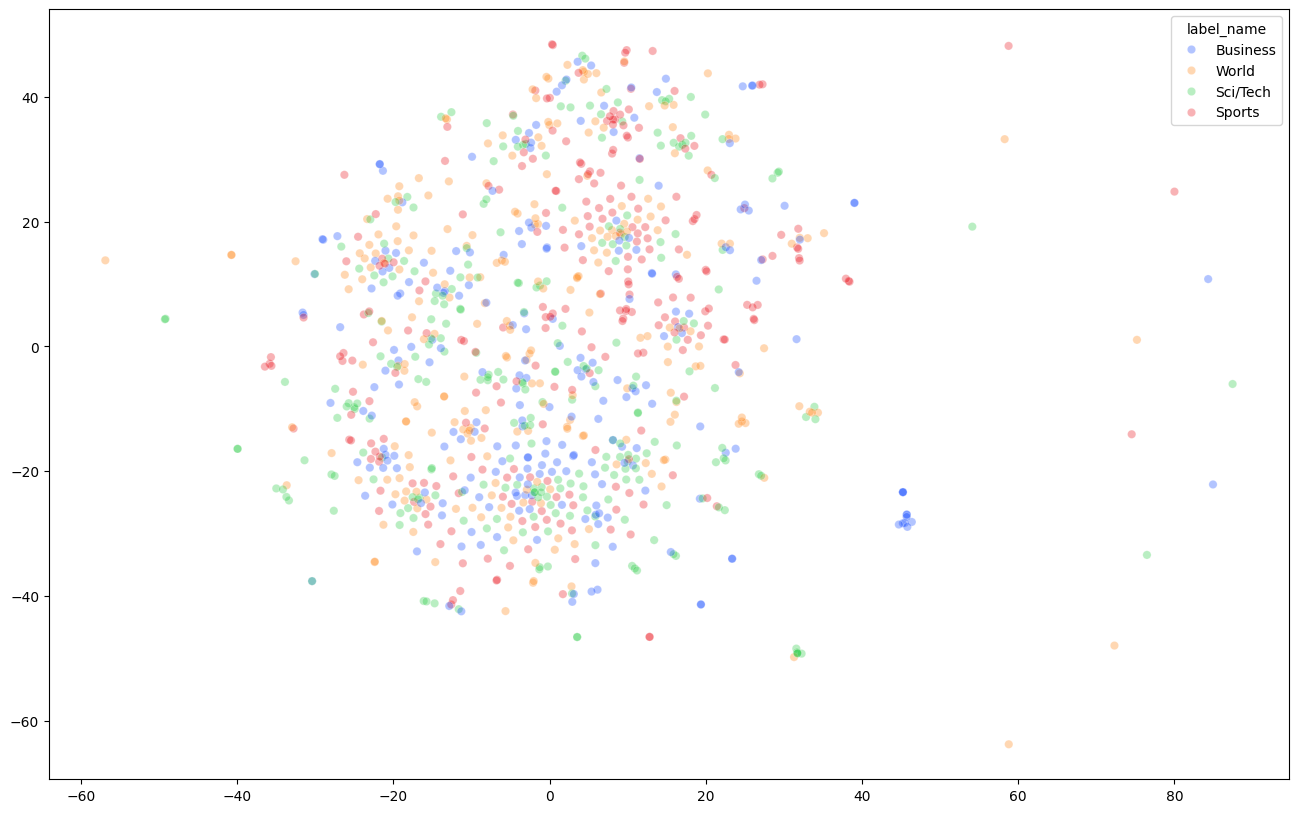

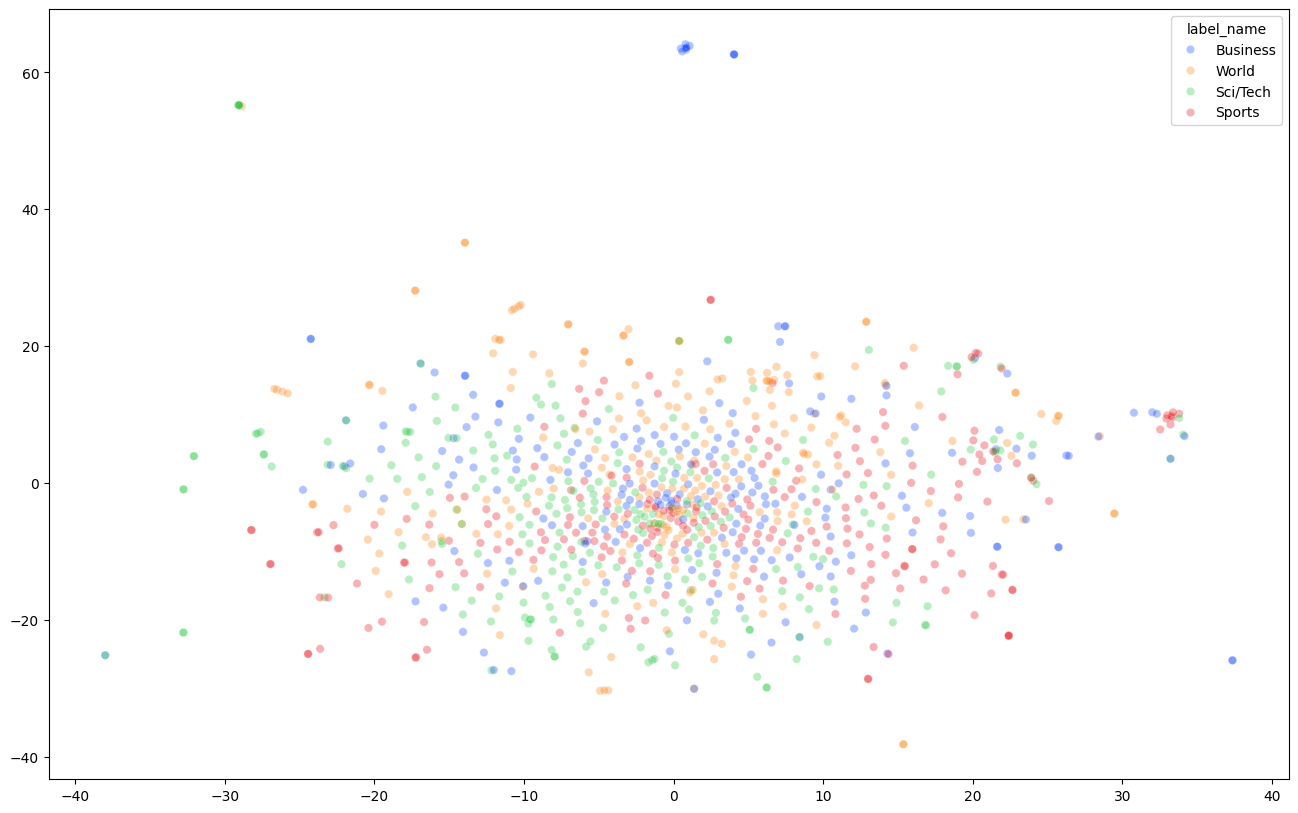

In [77]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# fist a t-sne of representations computed without using stopwords
# use the labels as hue
vectorizer = CountVectorizer()
train_count_matrix = vectorizer.fit_transform(traindf.text)
X_train=train_count_matrix
y_train=traindf.label_name

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.score(X_train,y_train)

test_count_matrix = vectorizer.transform(testdf.text)
X_test = test_count_matrix
y_test = testdf.label_name
predictions = clf.predict(X_test)
clf.score(X_test,y_test)

tsne_results = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_test)

plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=testdf.label_name,
    palette=sns.color_palette("bright", 10),
    legend="full",
    alpha=0.3
)


# then a t-sne of representations computed using stopwords
vectorizer = CountVectorizer(stop_words = 'english')
train_count_matrix = vectorizer.fit_transform(traindf.text)
X_train=train_count_matrix
y_train=traindf.label_name

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.score(X_train,y_train)

test_count_matrix = vectorizer.transform(testdf.text)
X_test = test_count_matrix
y_test = testdf.label_name
predictions = clf.predict(X_test)
clf.score(X_test,y_test)

tsne_results = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_test)

plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=testdf.label_name,
    palette=sns.color_palette("bright", 10),
    legend="full",
    alpha=0.3
)

In [72]:
len(tsne_results[:,1])

1000

Now, let's explore a second vectorization strategy, which is more efficient than pure term frequency: TF-IDF (Term Frequency-Inverse Document Frequency).

**What's the difference compared to the previous method?**

TF-IDF takes into account not only the frequency of terms in a document but also their importance in the entire corpus. It assigns higher weights to terms that are frequent in a document but rare across all documents. This helps in distinguishing important terms from common ones.

To implement TF-IDF vectorization, you can use [scikit-learn's `TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Once you've vectorized the documents, train a classification algorithm to classify them. Afterward, print the score obtained on the testing set and the corresponding confusion matrix.


test score 0.852


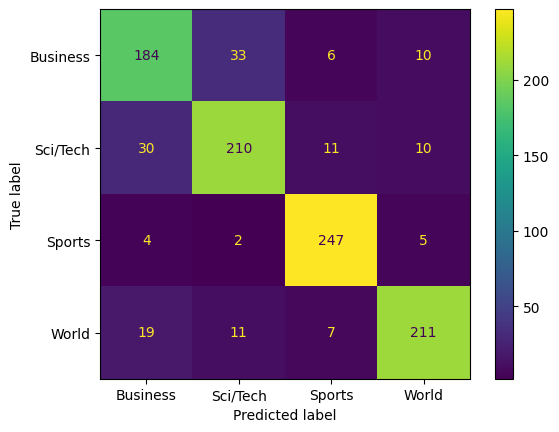

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_count_matrix = vectorizer.fit_transform(traindf.text)
X_train=train_count_matrix
y_train=traindf.label_name

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

test_count_matrix = vectorizer.transform(testdf.text)
X_test = test_count_matrix
y_test = testdf.label_name
predictions = clf.predict(X_test)
print("test score", clf.score(X_test,y_test))
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()




Plot a t-SNE of the representations obtained using TF-IDF.

<ipython-input-79-2f73232f89e8>:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


<Axes: >

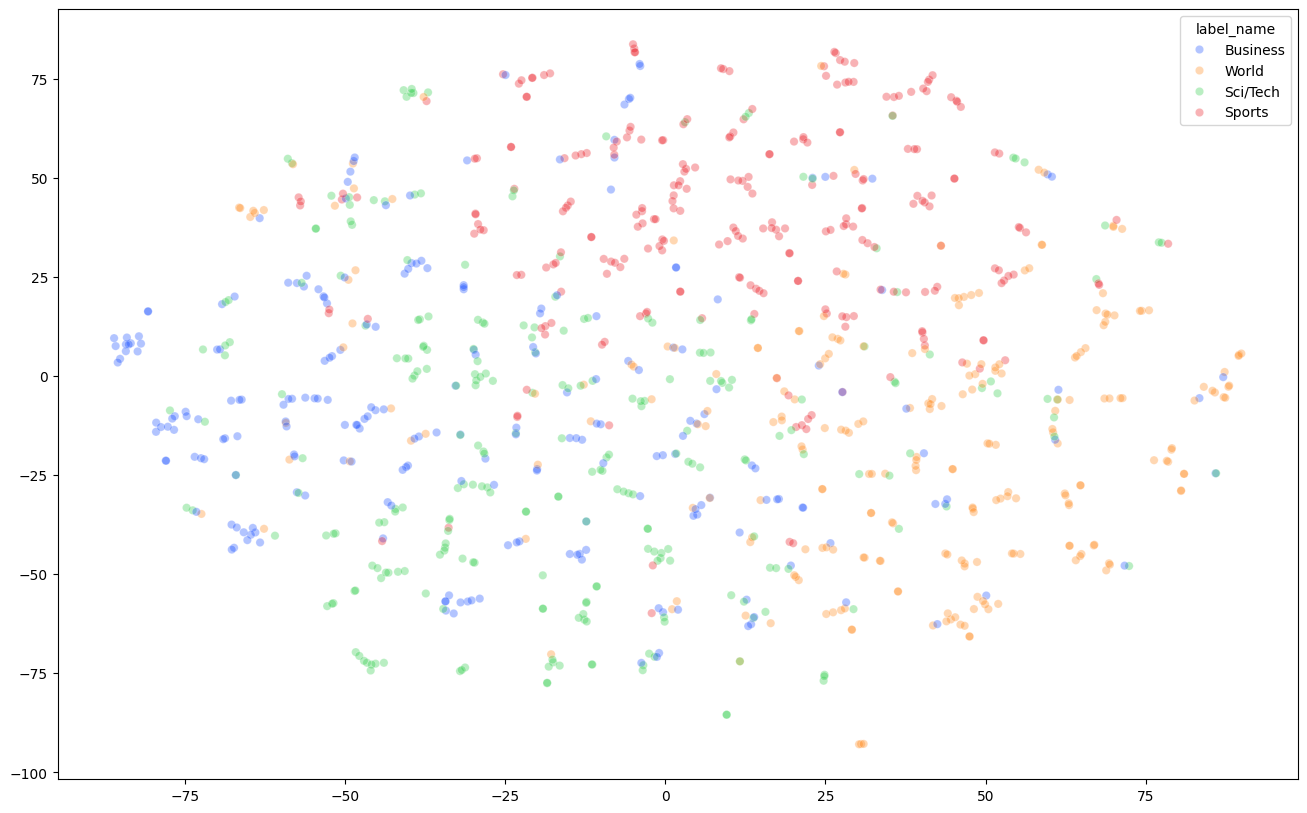

In [79]:
tsne_results = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_test)

plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=testdf.label_name,
    palette=sns.color_palette("bright", 10),
    legend="full",
    alpha=0.3
)

Both the ```TfidfVectorizer``` and ```CountVectorizer``` use a default strategy to create a token given a text using whitespaces and punctuations as separators.  
It is possible to provide custom __tokenizers__ to these vectorizers.  
Here we will use NLTK to build a more powerful tokenizer that will:

*   Revmove stop words
*   Convert all texts to lowercase
*   Ignore punctuations symbols
*   Only consider letters
*   Perform Stemming on every token



In [82]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords
import re


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
# Download stopwords list

stop_words = set(stopwords.words('english'))

# Interface lemma tokenizer from nltk with sklearn
class StemTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        doc = doc.lower()
        return [self.stemmer.stem(t) for t in word_tokenize(re.sub("[^a-z' ]", "", doc)) if t not in self.ignore_tokens]

tokenizer=StemTokenizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Print an example of text from the dataset and the corresponding tokens computed by the tokenizer.

In [83]:
text = traindf.text.values[0][:100]
print(text)
print(tokenizer(text))

Food is running so low aboard the international space station that flight controllers have instructe
['food', 'is', 'run', 'so', 'low', 'aboard', 'the', 'intern', 'space', 'station', 'that', 'flight', 'control', 'have', 'instruct']


Now provide the tokenizer to the a ```TfidfVectorizer``` and repeat the entire process.  
Does it improves the testing performance?  
Tips: you should also provide a tokenized version of the stopwords since we apply stemming on all tokens.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["upstopwordsasstopwordswhichstopwordshavenstopwordswillstopwordsdoingstopwordswhilestopwordsshouldstopwordsoffstopwordsyourselvesstopwordsit'sstopwordshisstopwordswherestopwordsdon'tstopwordswhostopwordsfromstopwordstheirsstopwordsyou'vestopwordstherestopwordswouldnstopwordswhenstopwordsoverstopwordsabovestopwordsoursstopwordsyourstopwordsitstopwordsherestopwordssostopwordsmstopwordsfurtherstopwordsmoststopwordshimstopwordscanstopwordsdidnstopwordshaven'tstopwordsbeingstopwordsmastopwordswon'tstopwordsostopwordswasnstopwordsaren'tstopwordsistopwordshestopwordsifstopwordsownstopwordsmorestopwordshasnstopword

test score 0.847


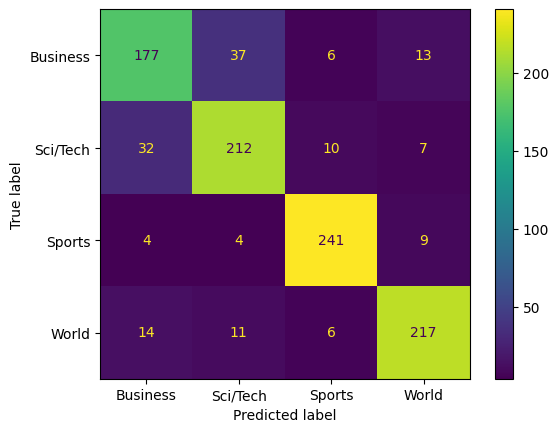

In [84]:
token_stop = tokenizer('stopwords'.join(stop_words))

tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer)
train_count_matrix = tfidf.fit_transform(traindf.text)
X_train=train_count_matrix
y_train=traindf.label_name

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

test_count_matrix = tfidf.transform(testdf.text)
X_test = test_count_matrix
y_test = testdf.label_name
predictions = clf.predict(X_test)
print("test score", clf.score(X_test,y_test))
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

<ipython-input-85-2f73232f89e8>:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


<Axes: >

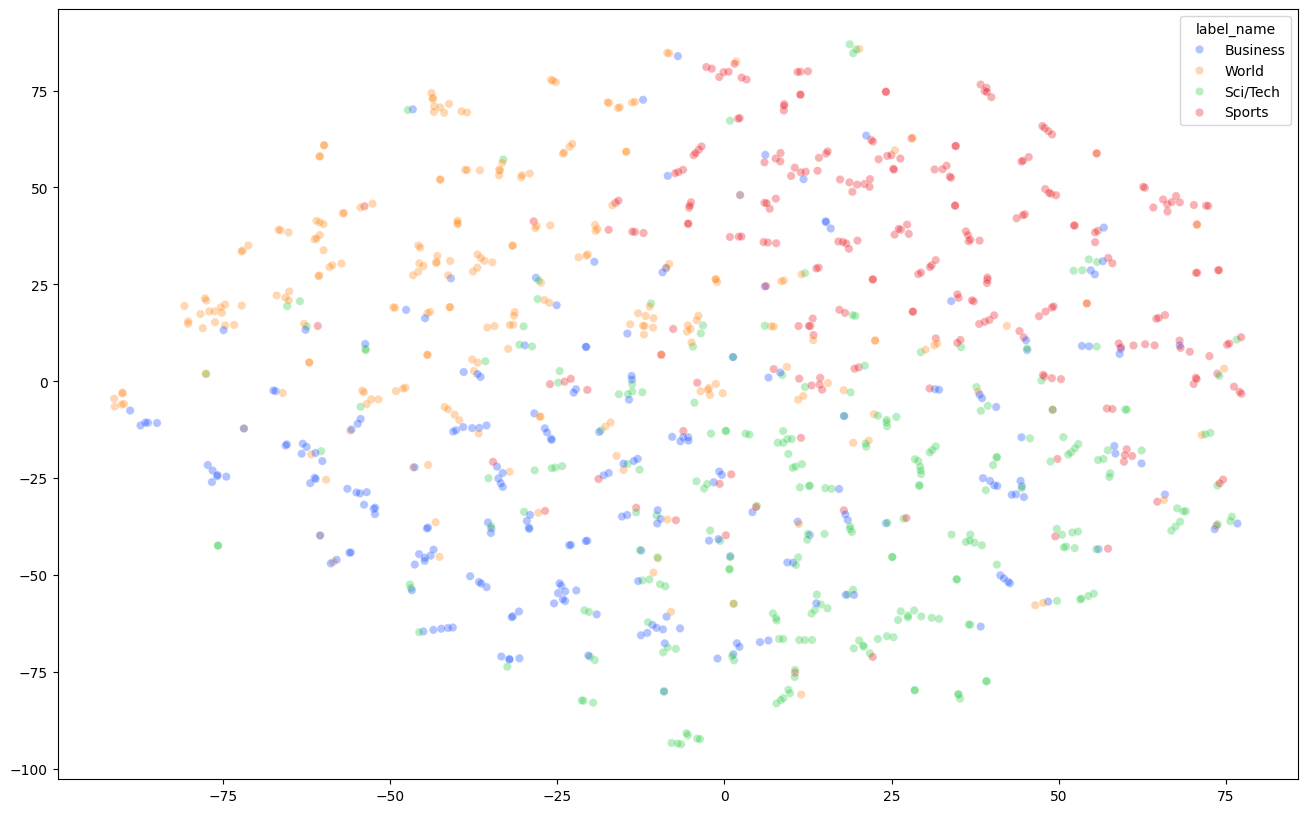

In [85]:
tsne_results = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_test)

plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=testdf.label_name,
    palette=sns.color_palette("bright", 10),
    legend="full",
    alpha=0.3
)

It is also possible to combine bag-of-words features with other features manually computed.  
The following code computes some new features on all documents.

In [86]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

def count_capital_words(string):
    return sum(map(str.isupper, string))

def count_capital_words(text):
  return sum(map(str.isupper,text.split()))

def count_punctuations(text):
  count = 0
  for i in range (0, len (text)):
    if text[i] in ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?"):
        count = count + 1;
  return  count

def count_sentences(text):
    return len(nltk.sent_tokenize(text))

def count_unique_words(text):
    return len(set(text.split()))

for df in [traindf, testdf]:
  df['count_chars'] = df.text.apply(lambda s: count_chars(s))
  df['count_words'] = df.text.apply(lambda s: count_words(s))
  df['count_capital_words'] = df.text.apply(lambda s: count_capital_words(s))
  df['count_capital_words'] = df.text.apply(lambda s: count_capital_words(s))
  df['count_punctuations'] = df.text.apply(lambda s: count_punctuations(s))
  df['count_sentences'] = df.text.apply(lambda s: count_sentences(s))
  df['count_unique_words'] = df.text.apply(lambda s: count_unique_words(s))
  df['avg_wordlength'] = df['count_chars']/df['count_words']
  df['avg_sentlength'] = df['count_words']/df['count_sentences']

Using a [```ColumnTransformer```](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) it is possible to combine all the features.

In [87]:
from sklearn.compose import ColumnTransformer

columns_to_keep = ['text', 'count_chars', 'count_words',
       'count_capital_words', 'count_punctuations',
       'count_unique_words', 'count_sentences', 'avg_wordlength',
       'avg_sentlength']

column_trans = ColumnTransformer(
    [('categories', TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer), 'text')],
    remainder='passthrough', verbose_feature_names_out=False)

X_train = column_trans.fit_transform(traindf[columns_to_keep])
X_test = column_trans.transform(testdf[columns_to_keep])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["upstopwordsasstopwordswhichstopwordshavenstopwordswillstopwordsdoingstopwordswhilestopwordsshouldstopwordsoffstopwordsyourselvesstopwordsit'sstopwordshisstopwordswherestopwordsdon'tstopwordswhostopwordsfromstopwordstheirsstopwordsyou'vestopwordstherestopwordswouldnstopwordswhenstopwordsoverstopwordsabovestopwordsoursstopwordsyourstopwordsitstopwordsherestopwordssostopwordsmstopwordsfurtherstopwordsmoststopwordshimstopwordscanstopwordsdidnstopwordshaven'tstopwordsbeingstopwordsmastopwordswon'tstopwordsostopwordswasnstopwordsaren'tstopwordsistopwordshestopwordsifstopwordsownstopwordsmorestopwordshasnstopword

Unfortunately, in our particular case, these features do not seem to lead to any improvement in testing performance.  
However, it's important to note that in different tasks, such as spam detection, these features can have a more pronounced and positive impact.


Model score on training data: 1.00
Model score on test data: 0.804


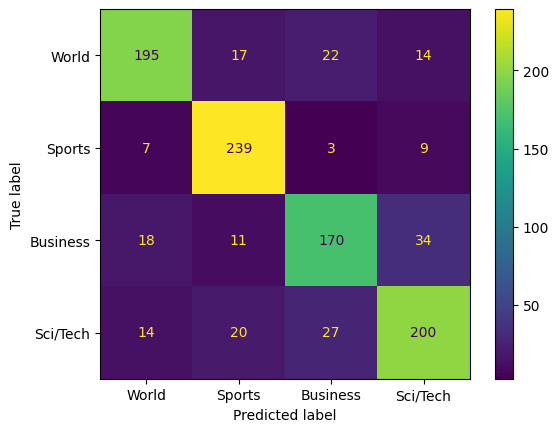

In [89]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, traindf.label)
print(f"Model score on training data: {rf.score(X_train, traindf.label):.2f}")
print(f"Model score on test data: {rf.score(X_test, testdf.label)}")

predictions = rf.predict(X_test)
cm = confusion_matrix(testdf.label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
disp.plot()
plt.show()

# Word Vectorization with Gensim and GloVe

In this section, we will explore another vectorization technique introduced during our course lectures: word vectorization. Specifically, we will use the Gensim library to work with pre-computed word embeddings.

To begin, we'll utilize pre-computed word embeddings called [GloVe](https://nlp.stanford.edu/projects/glove/). GloVe, which stands for "Global Vectors for Word Representation," is an innovative method for generating word embeddings.

GloVe embeddings are unique because they capture not only the local context of words within sentences but also the global context of words across the entire corpus. This is achieved through a specific training objective.

During the training of GloVe embeddings, the model aims to learn word representations in such a way that the dot product between the vectors of two words corresponds to the logarithm of their co-occurrence probability in the corpus. In other words, GloVe embeddings optimize to represent words in a way that reflects how often they appear together in the same context. This results in vector representations that capture meaningful semantic relationships between words.


In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip > /dev/null 2>&1

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = ('glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

The model is a mapping between words and their vector representations.  
Here is an exemple of representation:

In [ ]:
model['apple']

It also has usefull methods to explore the  vocabulary's embeddings.  
Here are some examples to find the most similar words in the embedding space.   
Try with some other words and look if the most similar words seem plausibles.

In [ ]:
model.most_similar('zuckerberg')
# model.most_similar('google')
# model.most_similar('intelligence')
# model.most_similar(negative='network')

An other cool feature of Word2Vec is the possibility to perform analogies.  
The most famous example is certainly king - man + woman = queen.  
Try to find other working analogies.

In [ ]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'])
# result = model.most_similar(positive=['paris', 'spain'], negative=['france'])
print("{}: {:.4f}".format(*result[0]))

In [ ]:
result = model.most_similar(positive=['beer', 'france'], negative=['usa'])
for i in range(3):
  print("{}: {:.4f}".format(*result[i]))

The following code plots a PCA or t-SNE representation of a list of words.  
Use this method with your own list of words to see wether similar words are close to each other in the embedding space.

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def plot_embeddings(model, words, reduction='pca'):
    word_vectors = np.array([model[w] for w in words])
    if reduction == PCA:
      reductor = PCA(n_components=2)
    elif reduction == "tsne":
      reductor = TSNE(2, perplexity=20)
    X = reductor.fit_transform(word_vectors)
    plt.figure(figsize=(12,12))
    plt.scatter(X[:,0], X[:,1])
    for word, x in zip(words, X):
        plt.text(x[0]+0.05, x[1]+0.05, word)


In [ ]:
word_list = ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute']

plot_embeddings(model, words=word_list, reduction='tsne')

We will now use these pre-computed embeddings to build the document representations.  
A simple way to compute a document representation from word embeddings consists in computing the mean or the sum of all the document's word embeddings.  
Here, since the documents do not have the same length, it is preferable to use the mean.  
Fill in the following code to compute the mean embeddings of all documents.  
Since this process is a little bit long, we will use a limited amount of documents during the practical session. Nonetheless, feel free to try with the complete dataset at home.  

In [ ]:
from tqdm import tqdm
tqdm.pandas()

traindf = pd.read_csv('train.csv', names=["label", "title", "text"]).sample(1000)
testdf = pd.read_csv('test.csv', names=["label", "title", "text"]).sample(200)

traindf['label'] = traindf['label'] -1
traindf['label_name'] = traindf.label.map({0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"})
testdf['label'] = testdf['label'] -1
testdf['label_name'] = testdf.label.map({0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"})

def compute_mean_embeddings(text, model, words_list, dim=100):
  text = ...# convert in lower case
  emb_list = [model[w] for w in text if w in words_list] # check if the word is in the vocabulary
  ...

words_list = model.index_to_key
traindf['mean_embeddings'] = traindf.text.progress_apply(lambda s: compute_mean_embeddings(s, model, words_list))
testdf['mean_embeddings'] = testdf.text.progress_apply(lambda s: compute_mean_embeddings(s, model, words_list))

The following code extracts the computed embeddings from the dataframe.  
Use these to train a model to predict the article category.  
Print your testing performance and plot a confusion matrix.  
The results may be a little bit disappointing. Any idea why?

In [ ]:
X_train = np.vstack(traindf['mean_embeddings'].values)
X_test = np.vstack(testdf['mean_embeddings'].values)

...

Plot a t-SNE of the computed embeddings.  
Does it look like good representations to classify documents?

In [ ]:
tsne = TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(X_train)

...

Word2Vec is an self-supervised learning of words represenations. Thus all words representations are meaningfull and have an equal impact when computing the mean.  This means that category irrelevant words have an equal importance in the document average represenatation than other words more related to the category.  
Computing the average of word embeddings learned with self-supervised learning is not very efficient for document classification.  
In the following we will see two alternatives using deep neural networks:


1.   Learn our word embeddings at the same time as we learn the classification function
2.   Replace the mean by a recurrent layer responsible for filtering informative words within the sequence



In this section, we will harness the flexibility of PyTorch to work with word embeddings. First, we'll proceed by downloading the dataset and preparing it to be compatible with PyTorch.

Using PyTorch for embeddings provides us with greater flexibility and control over the embedding process. This allows us to tailor embeddings to our specific needs and integrate them seamlessly into deep learning models for various natural language processing tasks.

In [ ]:
pip install -U portalocker>=2.0.0 2>&1

You may need to restart your runtime at this point if the next cell returns an error.

In [ ]:
import torch
from torchtext.datasets import AG_NEWS

train_iter = iter(AG_NEWS(split="train"))
next(train_iter)

In this step, we will take advantage of PyTorch's integrated tokenizers, specifically the "**basic_english**" tokenizer.   
The code provided below will tokenize our text data and establish the necessary vocabulary required for our embedding layers.

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

We will also load the GloVe embeddings for later.

In [ ]:
import torch
import torch.nn as nn

def load_glove_embeddings(path, vocab, embedding_dim):
    # Load GloVe embeddings into a dictionary
    glove_embeddings = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            glove_embeddings[word] = vector

    # Create a weights matrix for words in vocab
    weights_matrix = torch.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            weights_matrix[idx] = glove_embeddings[word]
        else:
            weights_matrix[idx] = torch.randn(embedding_dim)  # or torch.zeros(embedding_dim)

    return weights_matrix

embedding_dim = 100
glove_path = "glove.6B.100d.txt"
weights_matrix = load_glove_embeddings(glove_path, vocab, embedding_dim)

The following method converts a text in tokens.

In [ ]:
def process_text(text):
    return torch.tensor(vocab(tokenizer(text)), dtype=torch.int64)
process_text('here is the an example')

__Creating a Custom DataLoader for Texts__

In this section, we will set up a custom DataLoader for our text data. This involves some advanced PyTorch techniques. If you prefer to skip the details and proceed directly, you can safely run the next cell, which provides a custom DataLoader. However, if you're interested in understanding what's happening under the hood, here's what we're doing:

**Understanding `collate_fn` in DataLoader:**

Before your data is fed into your model for training or inference, it goes through a crucial function called `collate_fn`. Here's what you need to know about it:

- **Batch Processing**: DataLoader groups your data into batches, where each batch contains a specified number of data samples. The input to `collate_fn` is one of these batches.

- **Data Processing Pipelines**: Prior to using DataLoader, you typically create data processing pipelines to convert your raw data into a format suitable for your model. `collate_fn` is responsible for applying these transformations to each batch of data.

- **Top-Level Function**: It's essential to define `collate_fn` as a top-level Python function, not nested within other functions. This ensures that the function is accessible to all worker processes, which is crucial for parallel processing.

Additionally, as we create our custom DataLoader, we will keep track of the length of each text. This information will be useful later when we use an RNN (Recurrent Neural Network) for processing sequences of varying lengths.


In [ ]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collate Function for DataLoader
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_label, _text) in batch:
         label_list.append(_label - 1)  # Adjusting label to 0-based index
         processed_text = process_text(_text)
         text_list.append(processed_text)
         lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return text_list.to(device), label_list.to(device), lengths.to(device)

train_iter, test_iter = AG_NEWS(split=('train', 'test'))
train_loader = DataLoader(train_iter, batch_size=8, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_iter, batch_size=8, shuffle=True, collate_fn=collate_batch)

# Designing Our Neural Network Classifier

Now, let's design our neural network classifier for text classification. The model consists of several key components:

1. **Embedding Layer**: The initial layer of the model is an embedding layer that converts tokens into learnable embeddings. These embeddings capture the semantic meaning of words in our text data.  
Here we will let the possibility to use pre-trained GloVe representations without modifying them to compare the performance obtained with custom embeddings or GloVe.

2. **Mean Pooling**: Similar to our previous approach with Gensim, we will compute the mean of all the token embeddings within the text to create a global text embedding. This global representation captures the overall content of the text.

3. **Linear Layer**: A linear layer will follow, which takes the global text embedding as input and predicts the class label according to this representation.

Complete the following code to create the model described above.

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, use_pre_trained=False):
        super(TextClassificationModel, self).__init__()
        if use_pre_trained:
          self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze=True)
        else:
          self.embedding = nn.Embedding(vocab_size, embed_dim)

        # self.embedding.weight.requires_grad = False
        self.fc = nn.Linear(embed_dim, num_class)

    def get_embeddings(self, text):
        embedded = self.embedding(text)
        return ...# compute the mean of the embeddings

    def forward(self, text):
        embedded = self.get_embeddings(text)
        return ...# compute the logits i.e. the output of the linear layer

Complete the following training and testing functions.

In [ ]:
from tqdm.notebook import tqdm

def train(model, dataloader, optimizer, criterion, epochs=5):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    total = 0
    t = tqdm(dataloader)
    for i, (text, labels, _) in enumerate(t):

      pred = ...
      loss = criterion(..., ...)

      _, predicted = pred.max(1)
      running_corrects += predicted.eq(labels).sum().item()
      total += labels.size(0)
      running_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      t.set_description(f"epoch:{epoch} loss: {(running_loss / (i+1)):.4f} current accuracy:{round(running_corrects / total * 100, 2)}%")

def test(model, dataloader):
    model.eval()
    test_corrects = 0
    total = 0
    with torch.no_grad():
        for text, labels, _ in dataloader:
            pred = ...
            _, predicted = pred.max(1)
            test_corrects += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return test_corrects / total

Now compare the performance of this neural classifier when using pre-trained GloVe embeddings or embeddings computed from scratch.

In [ ]:
LR = 0.005
num_class = 4
vocab_size = len(vocab)
embedding_dim = 100
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(...)
train(...) # train the model for 5 or 10 epochs
test(...)

In [ ]:
# model with pre-trained embeddings
model = TextClassificationModel(vocab_size, embedding_dim, num_class, True).to(device)
optimizer = ...
train(...)
test(...)

On the test set, get the embeddings of each text and plot them using a t-SNE.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

embeddings, labels = [], []
for texts, label, _ in test_loader:
    with torch.no_grad(): # we don't need to compute the gradients
        embeddings.append(...) # you need to send the embeddings to the cpu and convert them to numpy: .cpu().numpy()
        labels.extend(...) # same here

embeddings = np.vstack(embeddings)
labels = np.array(labels)

X_tsne = TSNE(n_components=2, random_state=0).fit_transform(embeddings)

plot_data = pd.DataFrame({'TSNE1': X_tsne[:, 0], 'TSNE2': X_tsne[:, 1], 'Label': labels})
plt.figure(figsize=(16, 10))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Label", palette=sns.color_palette("hls", len(np.unique(labels))), data=plot_data, legend="full")
plt.show()


# Adding Recurrence with LSTM Layers

To enhance our network's capacity for understanding sequential data, we will incorporate [LSTM layers](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) into our model. The following code snippet implements a recurrent neural network (RNN) using LSTM layers.

A subtlety in this implementation lies in the use of the `pack_padded_sequence` method. This method is employed to handle sequences of varying lengths. Since not all sequences within a batch have the same length, we need to create "fake" empty tokens to ensure that all elements within a batch have the same dimension. This is precisely what the `pack_padded_sequence` method accomplishes.

Additionally, we'll use the last hidden representation of the LSTM as the embedding for the global text representation.

Furthermore, it's crucial to note that, since we need to send the lengths of the texts to the model, we will have to include this information within the `forward` method. This modification will also necessitate adjustments in our training and testing methods.


In [ ]:
import torch.nn as nn

class RecurrentTextClassifier(nn.Module):

  def __init__(self, vocab_size, embedding_dim, output_dim=4):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, sparse=True)
    self.lstm = nn.LSTM(embedding_dim,
                        100,
                        num_layers=2,
                        dropout=0.2,
                        batch_first=True)
    self.fc = nn.Linear(100, output_dim)

  def forward(self, text, text_lengths):
      embedded = self.get_embeddings(text, text_lengths)
      outputs=self.fc(embedded)
      return outputs


  def get_embeddings(self, text, text_lengths):
      embedded = self.embedding(text)
      #packed sequence
      packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
      _, (hidden, cell) = self.lstm(packed_embedded)
      return hidden[-1]

In [ ]:
def train(model, dataloader, optimizer, criterion, epochs=5):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    total = 0
    t = tqdm(dataloader)
    for i, (text, labels, text_lengths) in enumerate(t):

      pred = model(text, text_lengths).squeeze() #convert to 1D tensor
      loss = criterion(pred, labels)

      _, predicted = pred.max(1)
      running_corrects += predicted.eq(labels).sum().item()
      total += labels.size(0)
      running_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      t.set_description(f"epoch:{epoch} loss: {(running_loss / (i+1)):.4f} current accuracy:{round(running_corrects / total * 100, 2)}%")

def test(model, dataloader):
  model.eval()
  test_corrects = 0
  total = 0
  with torch.no_grad():
      for text, labels, text_lengths in dataloader:
          pred = model(text, text_lengths).squeeze()
          _, predicted = pred.max(1)
          test_corrects += predicted.eq(labels).sum().item()
          total += labels.size(0)
  return test_corrects / total

Train a reccurent model.

In [ ]:
model = RecurrentTextClassifier(...)
criterion = ...
optimizer = ...
train(...)
test(...)

Plot the corresponding representatons on a t-SNE.

In [ ]:
embeddings, labels = [], []
...

# Transformers: Revolutionizing Natural Language Processing

Transformers models have emerged as the cutting-edge technology in the field of natural language processing (NLP). They have significantly advanced the capabilities of NLP models, achieving state-of-the-art performance on various tasks.

[Hugging Face](https://huggingface.co/) offers one of the most practical and comprehensive [libraries](https://huggingface.co/docs/transformers/main/en/index) for working with transformers and pre-trained models.

**Hugging Face Transformers**: This library provides a user-friendly and powerful toolkit for working with transformers. It offers access to a wide range of pre-trained transformer models, making it easier than ever to leverage the latest advancements in NLP. With Hugging Face Transformers, you can quickly implement transformer-based solutions for tasks such as text classification, machine translation, and question-answering.

Hugging Face Transformers has become an essential resource for NLP practitioners, researchers, and developers, streamlining the process of incorporating state-of-the-art transformer models into their projects.


In [ ]:
!pip install transformers datasets 2>&1
!pip install accelerate -U  2>&1
!pip install transformers[torch]  2>&1

We will use the Hugging Face Transformers library to implement a transformer-based text classifier.  
First, we will load our data and prepare it for use with torch and the transformers library.

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv', names=["label", "title", "text"]).sample(40000)
test_df = pd.read_csv('test.csv', names=["label", "title", "text"]).sample(2000)
train_text, train_labels = train_df["text"], train_df['label']-1
test_text, test_labels = test_df["text"], test_df['label']-1

We will use the `distilbert-base-uncased` model, which is a distilled version of the popular [BERT](https://arxiv.org/abs/1810.04805) model. Distilled models are smaller and faster than their full-size counterparts, making them ideal for applications with limited computational resources.  
BERT uses a particular tokenization method called [WordPiece](https://huggingface.co/learn/nlp-course/chapter6/6?fw=pt), which is different from the tokenization method we used previously. Therefore, we will need to use the `DistilBertTokenizer` class to tokenize our data.  

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

class NlpDataset(Dataset):
    def __init__(self,data,labels,tokenizer):
        self.data = data.to_list()
        self.labels = labels.tolist()
        self.encodings = tokenizer(self.data, truncation=True, padding=True)

    def __getitem__(self,idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx],dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = NlpDataset(train_text, train_labels, tokenizer)
test_dataset = NlpDataset(test_text,test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Look at a sample yielded by your train loader.  
Its a dictionary with the following keys:
- input_ids: the tokenized text
- attention_mask: a mask to ignore padding
- labels: the labels

Input_ids are the tokenized text and labels are the labels.  
The attention mask is a mask to ignore padding. Indeed, the model will pad the sequences to have the same length. The attention mask will tell the model to ignore the padding.  

In [ ]:
next(iter(train_loader))

We will now instanciate our model and wrapp it into a Pytorch module.
In this practical session we will freeze the model and only train the last layer.  
This is not the best practice when using BERT but we will do it for the sake of simplicity.  
Take a particular attention to the `forward` method.  
The model will return a tuple with the logits, the hidden states and the attentions.  
The logits are the outputs of the last layer.
The hidden states are the outputs of all the layers and will contain the embeddings of the text.
The attentions are the attention weights of the model.

In [ ]:
from transformers import  DistilBertForSequenceClassification
import torch.nn as nn

class BertClf(nn.Module):

    def __init__(self, distilbert):

        super(BertClf, self).__init__()

        self.distilbert = distilbert
        for name, param in distilbert.named_parameters():
            if not "classifier" in name:
                param.requires_grad = False

    def forward(self, sent_id, mask):

        out = self.distilbert(sent_id, attention_mask=mask)
        logits = out.logits
        attn = out.attentions
        hidden_states = out.hidden_states


        return logits,hidden_states,attn

distilbert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                                  num_labels=4,
                                                                  output_attentions=True,
                                                                  output_hidden_states=True)

model = BertClf(distilbert)

Now complete the following training and testing functions.

In [ ]:
from tqdm.notebook import tqdm

def train_bert(model, optimizer, dataloader, epochs):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    total = 0
    t = tqdm(dataloader)
    for i, batch in enumerate(t):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        preds, _, _ = model(...)
        loss = criterion(...)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = preds.max(1)
        running_corrects += predicted.eq(labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

        t.set_description(f"epoch:{epoch} loss: {(running_loss / (i+1)):.4f} current accuracy:{round(running_corrects / total * 100, 2)}%")

def test_bert(model, dataloader):
    model.eval()
    test_corrects = 0
    total = 0
    with torch.no_grad():
      for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        preds, _, _ = model(...)
        _, predicted = preds.max(1)
        test_corrects += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return test_corrects / total

We will now compare the performance of our transformer-based model with the previous models.  

In [ ]:
from transformers import AdamW

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(model.parameters(),lr = 1e-5)
criterion  = ...
n_epochs = 1

train_bert(model, optimizer, train_loader, n_epochs)
test_bert(model, test_loader)

The following function get the embeddings of each text.
BERT use a speacial token `[CLS]` to represent the whole text.  
We will use the hidden states of this token as the embeddings of the text.

In [ ]:
import numpy as np
test_loader = DataLoader(test_dataset, batch_size=1)


def get_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
      for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels.append(batch["labels"].item())

        _, emb, _ = model(input_ids,mask=attention_mask)
        last_layer_cls = emb[-1][:,0,:]
        embeddings.append(last_layer_cls.squeeze(0).squeeze(0))
    embeddings = np.array([e.cpu().numpy() for e in embeddings])
    return embeddings, labels

embeddings, labels = get_embeddings(model, test_loader)

Now plot the embeddings of each text on a t-SNE.  
What do you think of these representations?

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

...

We can use[ **bertviz** library](https://github.com/jessevig/bertviz) to visualize the attention weights of the model.
Remember that the attention weights are the weights of the attention mechanism of the model.
It is a mechanism that allows the model to focus on the most important words of the text.
Attention weights are very useful to understand how the model works and what it focuses on.

In [ ]:
!pip install bertviz

Here is a text example:

In [ ]:
from bertviz import model_view, head_view

sentence = test_df["text"].iloc[33]
tokenized = tokenizer(sentence)
print(sentence)
print(tokenized)

We will use the `model_view` function to visualize the attention weights of the model.  
Here, each row represents a layer of the model and each column represents a head of the model.
The darker the color, the higher the attention weight.  
You may observe that some attention heads catche different relations between words.


In [ ]:
inputs = torch.tensor(tokenized["input_ids"]).unsqueeze(0).to(device)
mask = torch.tensor(tokenized["attention_mask"]).unsqueeze(0).to(device)
outputs = model(inputs,mask = mask)
attention = outputs[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0])
model_view(attention, tokens)

The ```head_view``` function allows to visualize the attention weights of a particular head of the model.

In [ ]:
head_view(attention, tokens)

That's it for this practical session.
By now, you should have a good understanding of how to encode text data and use it to train a machine learning model.  
You should also be familiar with the latest advancements in NLP, including transformers and pre-trained models.   
We hope you enjoyed this practical session and that you will be able to apply what you've learned to your own projects.